## Prepare data and libraries

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import re
import string
import time
import torch
from textstat import sentence_count
import seaborn as sns

In [2]:
from gensim.models import LdaMulticore
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmarc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
load_ds = lambda source: pd.read_csv(source, sep=';', index_col=0)

In [4]:
jokes_i = 'information/jokes/jokes.csv'
squad_i = 'information/squad/squad.csv'
tatman_i = 'information/tatman/tatman.csv'

jokes_cu = 'information/jokes/jokescu.csv'
squad_cu = 'information/squad/squadcu.csv'
tatman_cu = 'information/tatman/tatmancu.csv'

jokes_dsi = 'information/jokes/jokesdsi.csv'
squad_dsi = 'information/squad/squaddsi.csv'
tatman_dsi = 'information/tatman/tatmandsi.csv'

jokes_mad = 'information/jokes/jokesmad.csv'
squad_mad = 'information/squad/squadmad.csv'
tatman_mad = 'information/tatman/tatmanmad.csv'

In [5]:
from tabulate import tabulate
def latex_table(ds):
    print(tabulate(ds, ds.columns, tablefmt='latex'))

# R. Tatman's Question-Answer Dataset

(topics assigned manually thanks to source articles provided for every question)

In [6]:
tatmands = load_ds(tatman_i)
tatmands.ArticleTitle = tatmands.ArticleTitle.str.lower()

In [8]:
tatmands_topic_bt = tatmands[['ArticleTitle', 'BT_Level']]

In [9]:
level_list = ["Knowledge", "Comprehension", "Application", "Analysis", "Synthesis", "Evaluation"]

In [ ]:
categories = pd.read_csv('tatmancategories.csv', sep=';', index_col=0)
categories_series = pd.Series(categories.Category, index=categories.index)
tatmands['Topic'] = tatmands.ArticleTitle.map(categories_series)

<Axes: xlabel='Topic'>

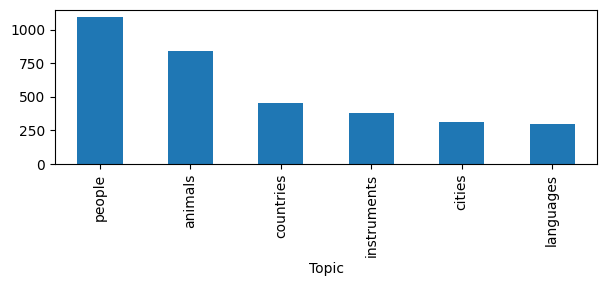

In [18]:
plt.figure(figsize=(7, 2))
tatmands.Topic.value_counts().plot(kind='bar')

## Bloom's Taxonomy level

In [19]:
tatman_category_counts = pd.crosstab(tatmands.Topic, tatmands.BT_Level)[level_list]

<Axes: xlabel='BT_Level', ylabel='Topic'>

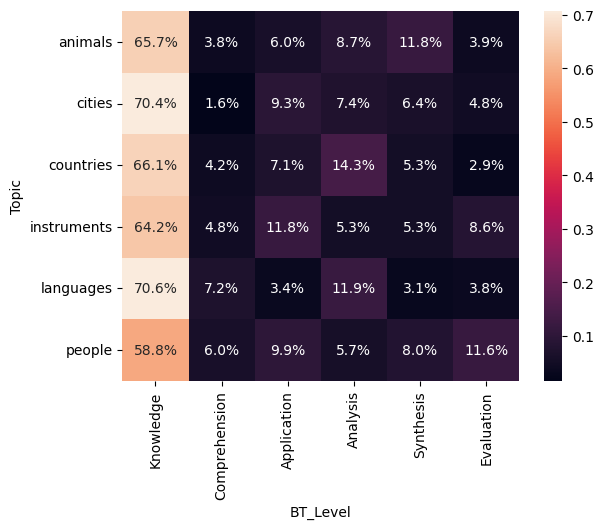

In [20]:
tatman_category_normalized = tatman_category_counts.div(tatman_category_counts.sum(axis=1), axis=0)
sns.heatmap(tatman_category_normalized, annot=True, fmt='.1%')

<Axes: xlabel='BT_Level', ylabel='Topic'>

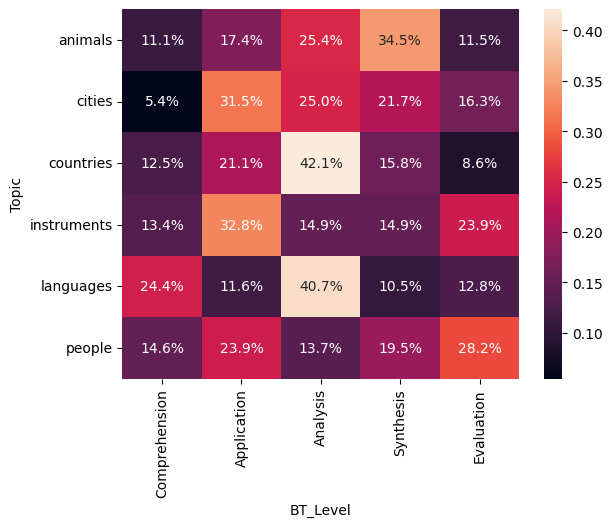

In [21]:
tatman_category_counts_2 = pd.crosstab(tatmands.Topic, tatmands.BT_Level)[level_list[1:]]
tatman_category_normalized_2 = tatman_category_counts_2.div(tatman_category_counts_2.sum(axis=1), axis=0)
sns.heatmap(tatman_category_normalized_2, annot=True, fmt='.1%')

## Answer-based measures

In [22]:
column_list = ['Topic', 'inf_droberta', 'inf_minilm', 'inf_mpnet', 'CU', 'DSI', 'MAD']

In [23]:
titles = ['information (all-distilroberta-v1)',
          'information (all-MiniLM-L12-v2)',
          'information (all-mpnet-base-v2)',
          'content uniqueness', 'DSI', 'MAD']

In [24]:
def sim_to_dist(sim):
    return np.sqrt(2*(1-sim))

def compile_ds(path0, path1, path2, path3):
    file0 = pd.read_csv(path0, sep=';', index_col=0)
    file1 = pd.read_csv(path1, sep=';', index_col=0)
    file2 = pd.read_csv(path2, sep=';', index_col=0)
    file3 = pd.read_csv(path3, sep=';', index_col=0)
    file0['inf_droberta'] = sim_to_dist(file0.inf_droberta)
    file0['inf_minilm'] = sim_to_dist(file0.inf_minilm)
    file0['inf_mpnet'] = sim_to_dist(file0.inf_mpnet)
    file0['DSI'] = file1.DSI
    file0['MAD'] = file2.MAD
    file0['CU'] = file3.CU2
    return file0

In [25]:
tatman_full = compile_ds(tatman_i, tatman_dsi, tatman_mad, tatman_cu)

In [26]:
tatman_full['Topic'] = tatman_full.ArticleTitle.str.lower().map(categories_series)
tatman_measures = tatman_full[column_list]
tatman_measures

,Topic,inf_droberta,inf_minilm,inf_mpnet,CU,DSI,MAD
0,people,0.210233,0.401719,0.402990,0.153846,0.117888,0.611123
1,people,0.307005,0.488957,0.569603,0.214286,NaN,0.789385
2,people,0.163184,0.296883,0.339485,0.166667,0.117888,0.597327
3,people,0.206537,0.381697,0.575907,0.230769,NaN,0.852998
4,people,0.226580,0.285996,0.272633,0.222222,0.134283,NaN
...,...,...,...,...,...,...,...
3353,animals,0.536047,0.705909,0.642058,0.470588,0.718054,0.561187
3354,animals,0.607786,0.657375,0.640330,0.500000,0.773617,NaN
3355,animals,0.440399,0.553044,0.521192,0.214286,0.474073,0.664397
3356,animals,0.358786,0.428073,0.380141,0.333333,0.527625,0.473988


In [27]:
column_list_A = ['Topic', 'inf_droberta', 'inf_minilm', 'inf_mpnet', 'CU', 'DSI', 'MAD']
column_list_B = column_list_A[1:]

def combine(ds_levels, ds_overall):
    level_order = ["overall"]+ds_levels.index.tolist()
    overall_row = ds_overall.to_frame().T
    stacked = pd.concat([overall_row, ds_levels])
    stacked.loc['overall'] = stacked.loc[0]
    return stacked.drop([0]).loc[level_order]

def value_stats(ds):    
    small_ds = ds[column_list_A]
    grouped = small_ds.groupby('Topic')
    smaller_ds = small_ds[column_list_B]
    means = combine(grouped.mean(), smaller_ds.mean())
    varis = combine(grouped.std(), smaller_ds.std())
    mins = combine(grouped.min(), smaller_ds.min())
    maxs = combine(grouped.max(), smaller_ds.max())
    return means, varis, mins, maxs

def meanvar(ds):
    vs = value_stats(ds)
    meanvar = vs[0]
    justvar = vs[1]
    for column in meanvar.columns:
        meanvar[column] = meanvar[column].map('{:,.3g}'.format) + " ± " + justvar[column].map('{:,.3g}'.format)
    return meanvar

def minmax(ds):
    vs = value_stats(ds)
    minmax = vs[2]
    justmax = vs[3]
    for column in minmax.columns:
        minmax[column] = minmax[column].map('{:,.3g}'.format) + " ÷ " + justmax[column].map('{:,.3g}'.format)
    return minmax

In [28]:
latex_table(meanvar(tatman_measures))

\begin{tabular}{lllllll}
\hline
             & inf\_droberta   & inf\_minilm    & inf\_mpnet     & CU            & DSI           & MAD           \\
\hline
 overall     & 0.339 ± 0.175  & 0.41 ± 0.181  & 0.415 ± 0.168 & 0.294 ± 0.161 & 0.414 ± 0.291 & 0.607 ± 0.198 \\
 animals     & 0.333 ± 0.164  & 0.414 ± 0.179 & 0.422 ± 0.168 & 0.32 ± 0.17   & 0.43 ± 0.294  & 0.593 ± 0.189 \\
 cities      & 0.367 ± 0.178  & 0.47 ± 0.198  & 0.451 ± 0.173 & 0.31 ± 0.158  & 0.473 ± 0.292 & 0.657 ± 0.19  \\
 countries   & 0.323 ± 0.164  & 0.4 ± 0.168   & 0.412 ± 0.155 & 0.289 ± 0.157 & 0.371 ± 0.279 & 0.633 ± 0.184 \\
 instruments & 0.331 ± 0.174  & 0.376 ± 0.176 & 0.387 ± 0.172 & 0.28 ± 0.145  & 0.431 ± 0.289 & 0.587 ± 0.208 \\
 languages   & 0.321 ± 0.162  & 0.402 ± 0.179 & 0.398 ± 0.17  & 0.293 ± 0.158 & 0.445 ± 0.299 & 0.692 ± 0.152 \\
 people      & 0.349 ± 0.188  & 0.407 ± 0.183 & 0.415 ± 0.167 & 0.278 ± 0.161 & 0.389 ± 0.288 & 0.574 ± 0.21  \\
\hline
\end{tabular}


In [29]:
latex_table(minmax(tatman_measures))

\begin{tabular}{lllllll}
\hline
             & inf\_droberta   & inf\_minilm    & inf\_mpnet     & CU             & DSI            & MAD             \\
\hline
 overall     & 0.0672 ÷ 1.03  & 0.074 ÷ 1.13  & 0.089 ÷ 1.12  & 0.0385 ÷ 0.902 & 0.0526 ÷ 0.836 & -0.347 ÷ 0.942  \\
 animals     & 0.1 ÷ 0.991    & 0.107 ÷ 0.938 & 0.117 ÷ 0.902 & 0.0435 ÷ 0.866 & 0.0545 ÷ 0.815 & -0.347 ÷ 0.927  \\
 cities      & 0.0918 ÷ 0.921 & 0.12 ÷ 0.903  & 0.156 ÷ 0.908 & 0.05 ÷ 0.815   & 0.0769 ÷ 0.836 & -0.0664 ÷ 0.927 \\
 countries   & 0.114 ÷ 0.923  & 0.074 ÷ 1.01  & 0.118 ÷ 1.01  & 0.0476 ÷ 0.812 & 0.0526 ÷ 0.815 & -0.0594 ÷ 0.923 \\
 instruments & 0.0672 ÷ 1.03  & 0.109 ÷ 1.13  & 0.089 ÷ 1.12  & 0.0385 ÷ 0.735 & 0.0631 ÷ 0.807 & -0.176 ÷ 0.915  \\
 languages   & 0.0895 ÷ 0.79  & 0.101 ÷ 0.809 & 0.106 ÷ 0.78  & 0.0444 ÷ 0.784 & 0.0608 ÷ 0.811 & 0.0993 ÷ 0.921  \\
 people      & 0.0874 ÷ 1.01  & 0.111 ÷ 1.01  & 0.108 ÷ 1.02  & 0.0435 ÷ 0.902 & 0.0565 ÷ 0.824 & -0.343 ÷ 0.942  \\
\hline
\end{tabular}


# LDA

## Question-Answer Jokes

In [30]:
NUM_TOPICS = 12

In [31]:
def remove_stopwords(sentence):
    question_removed = [word for word in sentence if (word not in stop_words) and (word not in string.punctuation)]
    return question_removed

def cleanup(sentence):
    return remove_stopwords(word_tokenize(sentence))

In [32]:
import pprint

# function to find and print all the topics in the dataset (found by LDA, so as collections of words)
def find_print_topics(ds, **kwargs):
    question_column = list(ds.Question)
    sentences = [cleanup(sentence) for sentence in question_column]
    
    id2word = corpora.Dictionary(sentences)
    corpus = [id2word.doc2bow(q) for q in sentences]
    
    if kwargs:
        lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=NUM_TOPICS, random_state=12, **kwargs)
    else:
        lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=NUM_TOPICS, random_state=12)
    
    pprint.pprint(lda_model.print_topics())
    return corpus, lda_model

In [33]:
jokesds = compile_ds(jokes_i, jokes_dsi, jokes_mad, jokes_cu)

C:\Users\kmarc\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [34]:
corpus_jokes, lda_jokes = find_print_topics(jokesds)

[(0,
  '0.063*"\'s" + 0.014*"difference" + 0.011*"trump" + 0.011*"\'t" + '
  '0.009*"favorite" + 0.008*"call" + 0.007*"sex" + 0.007*"get" + 0.006*"hear" '
  '+ 0.006*"part"'),
 (1,
  '0.032*"call" + 0.014*"common" + 0.012*"hear" + 0.009*"\'s" + 0.007*"\'t" + '
  '0.007*"difference" + 0.006*"tell" + 0.006*"like" + 0.005*"man" + '
  '0.005*"take"'),
 (2,
  '0.037*"call" + 0.021*"say" + 0.009*"hear" + 0.007*"know" + 0.006*"one" + '
  '0.006*"\'s" + 0.005*"go" + 0.005*"get" + 0.005*"ghost" + 0.004*"legs"'),
 (3,
  '0.047*"\'s" + 0.016*"call" + 0.011*"say" + 0.009*"get" + 0.008*"\'t" + '
  '0.007*"hear" + 0.007*"man" + 0.007*"know" + 0.007*"would" + 0.006*"best"'),
 (4,
  '0.025*"say" + 0.018*"call" + 0.013*"know" + 0.011*"man" + 0.011*"\'t" + '
  '0.009*"get" + 0.008*"people" + 0.007*"one" + 0.007*"\'s" + 0.006*"many"'),
 (5,
  '0.047*"call" + 0.032*"\'s" + 0.019*"\'t" + 0.014*"difference" + '
  '0.012*"common" + 0.009*"trump" + 0.008*"road" + 0.008*"eat" + '
  '0.008*"donald" + 0.007*"cro

In [35]:
def topic_names(lda_topics):
    topics = lda_topics.print_topics(num_words=20)
    topics_list = [[ingredient.split('"')[1] for ingredient in topic[1].split('+')] for topic in topics]
    all_main_words, amw_occurrences = np.unique(np.array(topics_list).flatten(), return_counts=True)
    names = []
    for topic in topics_list:
        occurrences = [amw_occurrences[all_main_words==word].item() for word in topic]
        rare_index = np.argmin(occurrences)
        names.append(topic[rare_index])
    return names

In [36]:
def display_topic_names(lda_topics):
    topics = lda_topics.print_topics(num_words=20)
    topics_list = [[ingredient.split('"')[1] for ingredient in topic[1].split('+')] for topic in topics]
    all_main_words, amw_occurrences = np.unique(np.array(topics_list).flatten(), return_counts=True)
    names = []
    for topic in topics_list:
        occurrences = [amw_occurrences[all_main_words==word].item() for word in topic]
        rare = np.min(occurrences)
        print([f'{topic[i]}: {occurrences[i]}' for i in range(len(topic)) if occurrences[i]==rare])

In [37]:
topic_names(lda_jokes)

['sex',
 'tried',
 'ghost',
 'always',
 'worst',
 'eat',
 'old',
 'jewish',
 'white',
 'change',
 'car',
 'called']

In [38]:
display_topic_names(lda_jokes)

['sex: 1', 'leg: 1']
['tried: 1', 'happens: 1', 'world: 1', 'chinese: 1', 'kids: 1']
['ghost: 1', 'legs: 1', 'fall: 1', 'cow: 1', 'dog: 1']
['always: 1', 'got: 1']
['worst: 2']
['eat: 1', '7: 1', 'baby: 1', 'someone: 1', 'iphone: 1', 'chicken: 1']
['old: 1', 'guy: 1', 'girlfriend: 1', 'ever: 1']
['jewish: 1', 'makes: 1', 'clop: 1', 'see: 1', 'hey: 1']
['white: 1']
['change: 1', 'light: 1', 'bulb: 1', 'lightbulb: 1', 'kind: 1', '``: 1']
['car: 1', '’: 1', '10: 1', 'snowman: 1']
['called: 1', 'pirate: 1', 'bad: 1', 'work: 1', 'computer: 1']


In [39]:
mapping = {'sex': 'leg', 'change': 'lightbulb', 'called': 'pirate'}

In [40]:
def assign_topics(corpus, lda_model, mapping):
    assigned_topics = []
    names = topic_names(lda_model)
    for corp in corpus:
        number = max(lda_model.get_document_topics(corp), key=lambda x: x[1])[0]
        if names[number] in mapping:
            assigned_topics.append(mapping[names[number]])
        else:
            assigned_topics.append(names[number])
    return assigned_topics

In [41]:
topic_numbers = assign_topics(corpus_jokes, lda_jokes, mapping)
topic_numbers

['worst',
 'pirate',
 'ghost',
 'pirate',
 'pirate',
 'worst',
 'leg',
 'eat',
 'car',
 'car',
 'car',
 'ghost',
 'always',
 'always',
 'eat',
 'lightbulb',
 'jewish',
 'pirate',
 'tried',
 'white',
 'ghost',
 'car',
 'car',
 'ghost',
 'eat',
 'pirate',
 'car',
 'old',
 'jewish',
 'leg',
 'worst',
 'pirate',
 'white',
 'white',
 'leg',
 'lightbulb',
 'ghost',
 'always',
 'eat',
 'worst',
 'always',
 'lightbulb',
 'leg',
 'eat',
 'leg',
 'pirate',
 'eat',
 'car',
 'worst',
 'eat',
 'old',
 'leg',
 'tried',
 'car',
 'leg',
 'car',
 'lightbulb',
 'car',
 'always',
 'pirate',
 'lightbulb',
 'leg',
 'eat',
 'leg',
 'tried',
 'leg',
 'tried',
 'white',
 'lightbulb',
 'always',
 'white',
 'worst',
 'ghost',
 'lightbulb',
 'tried',
 'eat',
 'leg',
 'lightbulb',
 'leg',
 'old',
 'pirate',
 'car',
 'eat',
 'leg',
 'car',
 'ghost',
 'jewish',
 'car',
 'pirate',
 'pirate',
 'pirate',
 'always',
 'car',
 'worst',
 'lightbulb',
 'jewish',
 'worst',
 'eat',
 'leg',
 'worst',
 'worst',
 'lightbulb',
 

In [42]:
jokesds['LDA_Topic'] = topic_numbers

In [43]:
jokesds[['LDA_Topic', 'inf_droberta']]

,LDA_Topic,inf_droberta
0,worst,0.459852
1,pirate,0.548835
2,ghost,0.319874
3,pirate,0.454307
4,pirate,0.555674
...,...,...
3996,leg,0.349947
3997,car,0.598019
3998,ghost,0.328398
3999,worst,0.596185


In [44]:
def LDA_histogram(ds, title):
    plt.figure(figsize=(7, 2))
    ds.LDA_Topic.value_counts().plot(kind='bar')
    plt.title(title)

In [45]:
def STM_histogram(ds, title):
    plt.figure(figsize=(7, 2))
    ds.STM_Topic.value_counts().plot(kind='bar')
    plt.title(title)

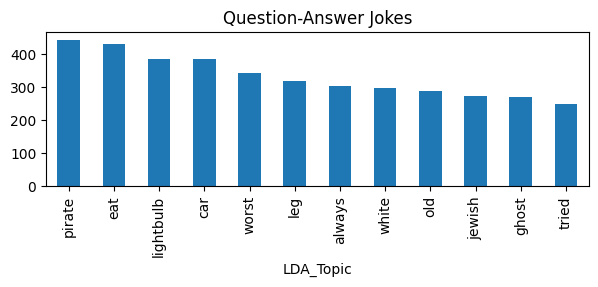

In [46]:
LDA_histogram(jokesds, 'Question-Answer Jokes')

In [47]:
def analysis_lda(ds):
    small_ds = ds[column_list[1:]]
    small_ds['Topic'] = ds.LDA_Topic
    return meanvar(small_ds), minmax(small_ds)

In [48]:
latex_table(analysis_lda(jokesds)[0])

\begin{tabular}{lllllll}
\hline
           & inf\_droberta   & inf\_minilm    & inf\_mpnet     & CU            & DSI           & MAD           \\
\hline
 overall   & 0.478 ± 0.133  & 0.516 ± 0.128 & 0.535 ± 0.135 & 0.4 ± 0.148   & 0.686 ± 0.13  & 0.705 ± 0.193 \\
 always    & 0.47 ± 0.138   & 0.511 ± 0.127 & 0.53 ± 0.136  & 0.389 ± 0.145 & 0.682 ± 0.127 & 0.697 ± 0.196 \\
 car       & 0.484 ± 0.128  & 0.525 ± 0.129 & 0.54 ± 0.131  & 0.419 ± 0.135 & 0.705 ± 0.108 & 0.758 ± 0.146 \\
 eat       & 0.471 ± 0.124  & 0.509 ± 0.124 & 0.529 ± 0.132 & 0.382 ± 0.142 & 0.692 ± 0.101 & 0.672 ± 0.215 \\
 ghost     & 0.473 ± 0.136  & 0.509 ± 0.131 & 0.541 ± 0.134 & 0.388 ± 0.152 & 0.671 ± 0.149 & 0.672 ± 0.208 \\
 jewish    & 0.472 ± 0.128  & 0.514 ± 0.127 & 0.539 ± 0.129 & 0.388 ± 0.153 & 0.656 ± 0.175 & 0.676 ± 0.191 \\
 leg       & 0.465 ± 0.13   & 0.51 ± 0.121  & 0.53 ± 0.137  & 0.402 ± 0.143 & 0.677 ± 0.147 & 0.724 ± 0.154 \\
 lightbulb & 0.465 ± 0.124  & 0.505 ± 0.124 & 0.52 ± 0.123  & 0.401 ± 

C:\Users\kmarc\AppData\Local\Temp\ipykernel_61260\2346855251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_ds['Topic'] = ds.LDA_Topic


In [49]:
latex_table(analysis_lda(jokesds)[1])

\begin{tabular}{lllllll}
\hline
           & inf\_droberta     & inf\_minilm    & inf\_mpnet     & CU             & DSI            & MAD              \\
\hline
 overall   & 0.000632 ÷ 1.29  & 0.153 ÷ 1.27  & 0.2 ÷ 1.2     & 0 ÷ 0.906      & 0.0529 ÷ 0.832 & -0.65 ÷ 0.961    \\
 always    & 0.206 ÷ 1.02     & 0.229 ÷ 1.07  & 0.223 ÷ 1.07  & 0.105 ÷ 0.805  & 0.085 ÷ 0.825  & -0.102 ÷ 0.933   \\
 car       & 0.189 ÷ 1.05     & 0.204 ÷ 1.06  & 0.242 ÷ 1.07  & 0.133 ÷ 0.827  & 0.0702 ÷ 0.813 & -0.141 ÷ 0.918   \\
 eat       & 0.181 ÷ 0.922    & 0.21 ÷ 1.06   & 0.25 ÷ 1.11   & 0.118 ÷ 0.765  & 0.0646 ÷ 0.821 & -0.65 ÷ 0.924    \\
 ghost     & 0.21 ÷ 1.29      & 0.153 ÷ 1.21  & 0.201 ÷ 1.19  & 0.1 ÷ 0.871    & 0.0638 ÷ 0.814 & -0.106 ÷ 0.93    \\
 jewish    & 0.206 ÷ 0.872    & 0.209 ÷ 0.943 & 0.298 ÷ 0.998 & 0.1 ÷ 0.75     & 0.0529 ÷ 0.823 & 0.0349 ÷ 0.924   \\
 leg       & 0.000632 ÷ 0.985 & 0.201 ÷ 1.06  & 0.2 ÷ 1.1     & 0.0952 ÷ 0.85  & 0.0601 ÷ 0.822 & -0.0161 ÷ 0.907  \\
 lightbulb & 0

C:\Users\kmarc\AppData\Local\Temp\ipykernel_61260\2346855251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_ds['Topic'] = ds.LDA_Topic


<Axes: xlabel='BT_Level', ylabel='LDA_Topic'>

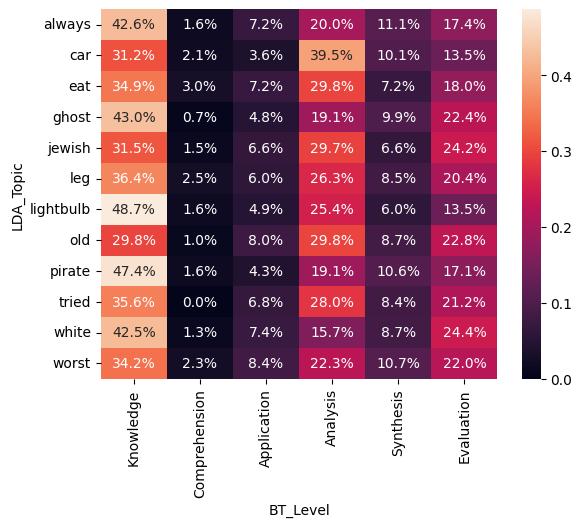

In [50]:
jokes_topic_counts = pd.crosstab(jokesds.LDA_Topic, jokesds.BT_Level)[level_list]
jokes_topic_normalized = jokes_topic_counts.div(jokes_topic_counts.sum(axis=1), axis=0)
sns.heatmap(jokes_topic_normalized, annot=True, fmt='.1%')

<Axes: xlabel='BT_Level', ylabel='LDA_Topic'>

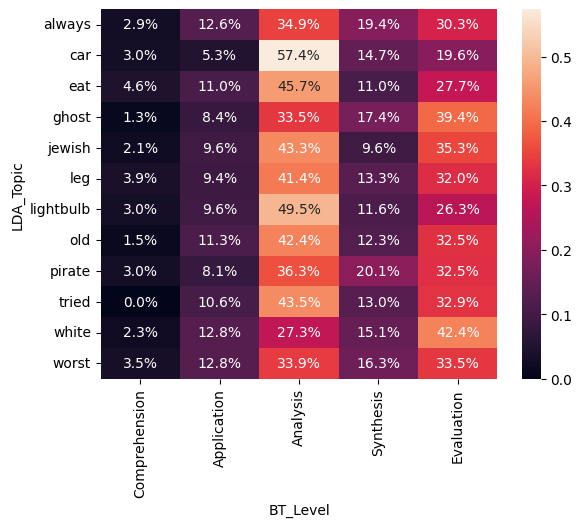

In [51]:
jokes_topic_counts = pd.crosstab(jokesds.LDA_Topic, jokesds.BT_Level)[level_list[1:]]
jokes_topic_normalized = jokes_topic_counts.div(jokes_topic_counts.sum(axis=1), axis=0)
sns.heatmap(jokes_topic_normalized, annot=True, fmt='.1%')

## Stanford Question Answering Dataset

In [52]:
squadds = compile_ds(squad_i, squad_dsi, squad_mad, squad_cu)

In [53]:
corpus_squad, lda_squad = find_print_topics(squadds)

[(0,
  '0.030*"\'s" + 0.015*"new" + 0.012*"york" + 0.012*"idol" + 0.011*"chopin" + '
  '0.010*"american" + 0.010*"first" + 0.009*"many" + 0.009*"city" + '
  '0.008*"name"'),
 (1,
  '0.019*"\'s" + 0.014*"chopin" + 0.008*"kanye" + 0.008*"new" + 0.007*"first" '
  '+ 0.006*"album" + 0.006*"york" + 0.006*"city" + 0.005*"dog" + '
  '0.005*"solar"'),
 (2,
  '0.024*"``" + 0.024*"\'s" + 0.015*"name" + 0.009*"kanye" + 0.008*"year" + '
  '0.008*"album" + 0.008*"beyoncé" + 0.006*"company" + 0.006*"west" + '
  '0.005*"season"'),
 (3,
  '0.010*"season" + 0.009*"new" + 0.008*"year" + 0.008*"kanye" + 0.008*"york" '
  '+ 0.008*"many" + 0.007*"\'s" + 0.007*"two" + 0.006*"portugal" + '
  '0.005*"become"'),
 (4,
  '0.014*"\'s" + 0.009*"name" + 0.008*"many" + 0.008*"new" + 0.008*"city" + '
  '0.007*"york" + 0.006*"chopin" + 0.006*"beyoncé" + 0.006*"type" + '
  '0.005*"kanye"'),
 (5,
  '0.023*"many" + 0.022*"\'s" + 0.018*"chopin" + 0.015*"notre" + 0.015*"dame" '
  '+ 0.013*"year" + 0.012*"name" + 0.012*"fir

In [54]:
display_topic_names(lda_squad)

['lee: 1']
['apple: 1']
['number: 1']
['become: 1', 'located: 1', 'population: 1']
['water: 1', 'release: 1']
['part: 1']
['book: 1', 'percentage: 1']
['song: 2', 'one: 2']
['world: 1', 'according: 1']
['game: 1', 'made: 1']
['released: 1']
['antibiotics: 1', 'average: 1']


In [55]:
squadds['LDA_Topic'] = assign_topics(corpus_squad, lda_squad, {})

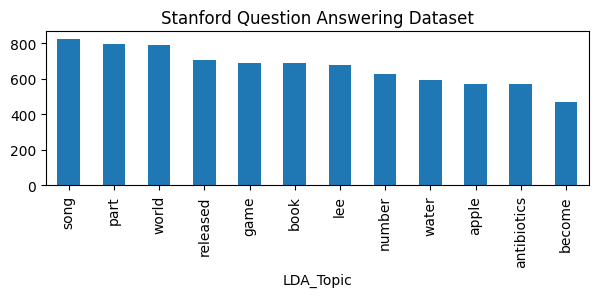

In [56]:
LDA_histogram(squadds, 'Stanford Question Answering Dataset')

In [57]:
latex_table(analysis_lda(squadds)[0])

\begin{tabular}{lllllll}
\hline
             & inf\_droberta   & inf\_minilm     & inf\_mpnet     & CU            & DSI            & MAD            \\
\hline
 overall     & 0.699 ± 0.129  & 0.672 ± 0.106  & 0.642 ± 0.107 & 0.658 ± 0.119 & 0.793 ± 0.0243 & 0.83 ± 0.0564  \\
 antibiotics & 0.69 ± 0.128   & 0.657 ± 0.105  & 0.631 ± 0.104 & 0.669 ± 0.111 & 0.79 ± 0.0275  & 0.83 ± 0.0548  \\
 apple       & 0.687 ± 0.13   & 0.67 ± 0.109   & 0.636 ± 0.114 & 0.658 ± 0.119 & 0.793 ± 0.0225 & 0.828 ± 0.05   \\
 become      & 0.695 ± 0.134  & 0.666 ± 0.109  & 0.638 ± 0.113 & 0.661 ± 0.127 & 0.795 ± 0.0249 & 0.828 ± 0.0559 \\
 book        & 0.693 ± 0.128  & 0.674 ± 0.104  & 0.634 ± 0.105 & 0.663 ± 0.126 & 0.791 ± 0.0254 & 0.824 ± 0.054  \\
 game        & 0.7 ± 0.126    & 0.662 ± 0.109  & 0.641 ± 0.105 & 0.654 ± 0.116 & 0.794 ± 0.0235 & 0.828 ± 0.0574 \\
 lee         & 0.715 ± 0.13   & 0.682 ± 0.0983 & 0.651 ± 0.101 & 0.656 ± 0.119 & 0.793 ± 0.0229 & 0.837 ± 0.0534 \\
 number      & 0.705 ± 0.137  

C:\Users\kmarc\AppData\Local\Temp\ipykernel_61260\2346855251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_ds['Topic'] = ds.LDA_Topic


In [58]:
latex_table(analysis_lda(squadds)[1])

\begin{tabular}{lllllll}
\hline
             & inf\_droberta   & inf\_minilm    & inf\_mpnet     & CU            & DSI           & MAD           \\
\hline
 overall     & 0.313 ÷ 1.22   & 0.277 ÷ 1.19  & 0.263 ÷ 1.21  & 0.116 ÷ 0.943 & 0.639 ÷ 0.848 & 0.486 ÷ 0.966 \\
 antibiotics & 0.365 ÷ 1.08   & 0.291 ÷ 0.985 & 0.312 ÷ 1     & 0.2 ÷ 0.913   & 0.663 ÷ 0.839 & 0.656 ÷ 0.953 \\
 apple       & 0.383 ÷ 1.22   & 0.383 ÷ 1.19  & 0.329 ÷ 1.21  & 0.25 ÷ 0.901  & 0.653 ÷ 0.844 & 0.664 ÷ 0.956 \\
 become      & 0.313 ÷ 1.1    & 0.295 ÷ 1.05  & 0.307 ÷ 0.999 & 0.148 ÷ 0.898 & 0.663 ÷ 0.848 & 0.569 ÷ 0.93  \\
 book        & 0.337 ÷ 1.13   & 0.331 ÷ 1.01  & 0.263 ÷ 1.04  & 0.211 ÷ 0.943 & 0.688 ÷ 0.837 & 0.647 ÷ 0.961 \\
 game        & 0.38 ÷ 1.11    & 0.277 ÷ 1.05  & 0.342 ÷ 0.997 & 0.217 ÷ 0.9   & 0.639 ÷ 0.845 & 0.605 ÷ 0.943 \\
 lee         & 0.325 ÷ 1.08   & 0.324 ÷ 0.988 & 0.358 ÷ 0.973 & 0.16 ÷ 0.911  & 0.711 ÷ 0.844 & 0.594 ÷ 0.939 \\
 number      & 0.357 ÷ 1.11   & 0.307 ÷ 1.05  & 0.346 

C:\Users\kmarc\AppData\Local\Temp\ipykernel_61260\2346855251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_ds['Topic'] = ds.LDA_Topic


<Axes: xlabel='BT_Level', ylabel='LDA_Topic'>

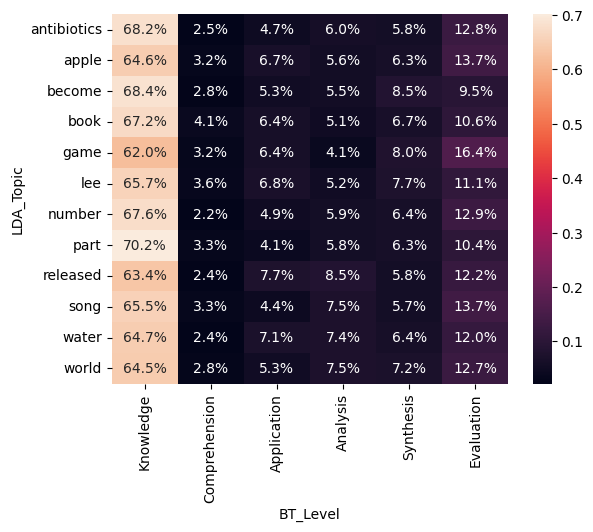

In [59]:
squad_topic_counts = pd.crosstab(squadds.LDA_Topic, squadds.BT_Level)[level_list]
squad_topic_normalized = squad_topic_counts.div(squad_topic_counts.sum(axis=1), axis=0)
sns.heatmap(squad_topic_normalized, annot=True, fmt='.1%')

<Axes: xlabel='BT_Level', ylabel='LDA_Topic'>

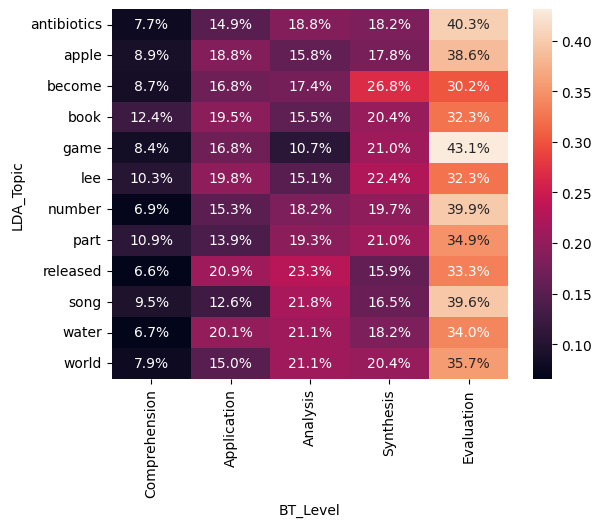

In [60]:
squad_topic_counts = pd.crosstab(squadds.LDA_Topic, squadds.BT_Level)[level_list[1:]]
squad_topic_normalized = squad_topic_counts.div(squad_topic_counts.sum(axis=1), axis=0)
sns.heatmap(squad_topic_normalized, annot=True, fmt='.1%')

# SeedTopicMine

In [61]:
topic_dict = {}
with open('topics_results.txt', 'r') as f:
    for line in f.readlines():
        topic_name, seeds = line.strip().split(':')
        topic_dict[topic_name] = seeds.split(',')

In [62]:
topic_dict

{'business': ['companies',
  'businesses',
  'business',
  'corporations',
  'corporate',
  'industry',
  'investment',
  'firms',
  'industries',
  'investments',
  "companies'",
  'multinational_corporations',
  'investors',
  'enterprises',
  'profits',
  'executives',
  'conglomerates',
  'multinationals',
  'retailing',
  'company'],
 'politics': ['political',
  'politics',
  'election',
  'politician',
  'politicians',
  'party',
  'elections',
  'political_party',
  'democratic_party',
  'political_parties',
  'electoral',
  'candidates',
  'candidate',
  'parliamentary',
  'elected',
  'democratic',
  'voter',
  'parties',
  'voters',
  'conservative_coalition'],
 'sports': ['sports',
  'sport',
  'sporting',
  'football',
  'games',
  'soccer',
  'basketball',
  'athletes',
  'players',
  'athletic',
  'athlete',
  'coaches',
  'game',
  'sporting_events',
  'athletics',
  'league',
  'tournament',
  'baseball',
  'basketball_team',
  'ice_hockey'],
 'health': ['medical',
  'h

In [63]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

def remove_stopwords(sentence):
    question_removed = [word for word in sentence if word not in stop_words]
    return question_removed

def cleanup(sentence):
    return word_tokenize(" ".join(remove_stopwords(sentence.split())))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmarc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
import pickle, bcolz
glove_path = 'glove_vectors'
vectors = bcolz.open(f'{glove_path}/6B.50.dat')[:]
words = pickle.load(open(f'{glove_path}/6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open(f'{glove_path}/6B.50_idx.pkl', 'rb'))
glove = {w: vectors[word2idx[w]] for w in words}
del vectors, words, word2idx

vectorize = lambda sentence: np.array([glove[word] for word in sentence if word in glove])

In [65]:
vectorize(topic_dict['business'])

array([[ 5.1809e-01, -1.1148e+00,  8.0542e-01,  7.4613e-01, -5.1765e-01,
         2.2329e-02, -1.1665e+00, -3.8518e-01,  2.5655e-01,  3.6769e-01,
         3.5820e-01,  7.0135e-01, -2.8008e-01, -1.2265e-01, -1.4963e-01,
         1.4381e-01, -1.4220e-01,  1.6931e-01,  3.6557e-01, -1.5110e+00,
         1.7301e+00, -6.0530e-01, -1.6457e-01, -1.6064e-01, -9.1074e-01,
        -1.3738e+00, -6.1214e-01, -9.3307e-01, -3.9919e-03, -3.0649e-01,
         3.7760e+00,  4.3728e-01,  6.5859e-01,  2.2101e-02,  4.3874e-02,
        -8.4600e-01, -9.9271e-01,  2.0027e-01,  1.4687e-01, -3.9595e-01,
        -2.5364e-01, -5.4625e-01,  1.2240e+00,  7.2737e-01,  1.8714e-01,
        -1.7607e-01, -1.1303e+00,  6.7082e-01, -1.6598e-01,  3.2113e-01],
       [ 6.0368e-01, -8.8534e-01,  7.8255e-01,  1.1335e-01, -2.7030e-01,
        -3.4863e-02, -1.1517e+00, -4.1252e-01,  1.3352e-01,  2.5751e-01,
        -9.0055e-02, -2.1679e-01,  2.4874e-01, -2.9210e-01, -1.9175e-01,
         2.1267e-01,  1.1233e-01,  8.7779e-02,  9.

In [66]:
topic_dict.keys()

dict_keys(['business', 'politics', 'sports', 'health', 'education', 'real_estate', 'arts', 'science', 'technology'])

In [67]:
X = np.vstack([vectorize(topic_dict[topic]) for topic in topic_dict])

In [68]:
indices = [[topic]*len(vectorize(topic_dict[topic])) for topic in topic_dict.keys()]

In [69]:
Y = np.array([index for indexes in indices for index in indexes])

In [70]:
Y.shape

(127,)

In [71]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate

In [72]:
classifier = GradientBoostingClassifier()
cv_results = cross_validate(classifier, X, Y, cv=5)
print(cv_results['test_score'])

[0.76923077 0.84615385 0.76       0.88       0.76      ]


In [73]:
classifier.fit(X, Y)

GradientBoostingClassifier()

In [74]:
def stm_topic(row):
    question = cleanup(row.Question)
    vector = np.mean(vectorize(question), axis=0)
    topic_number = classifier.predict(vector.reshape(1, -1)).item()
    return topic_number

In [75]:
jokesds['STM_Topic'] = [stm_topic(row) for index, row in jokesds.iterrows()]
squadds['STM_Topic'] = [stm_topic(row) for index, row in squadds.iterrows()]

In [76]:
def analysis_stm(ds):
    small_ds = ds[column_list[1:]]
    small_ds['Topic'] = ds.STM_Topic
    return meanvar(small_ds), minmax(small_ds)

## Question-Answer Jokes

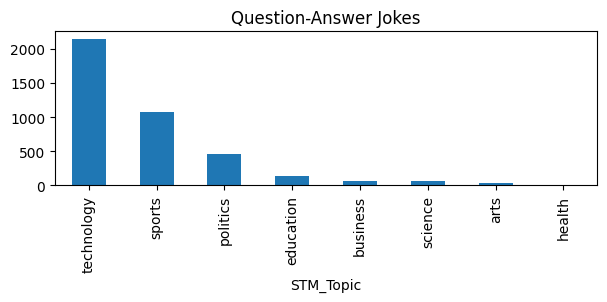

In [77]:
STM_histogram(jokesds, 'Question-Answer Jokes')

In [78]:
latex_table(analysis_stm(jokesds)[0])

\begin{tabular}{lllllll}
\hline
            & inf\_droberta   & inf\_minilm     & inf\_mpnet      & CU             & DSI           & MAD            \\
\hline
 overall    & 0.478 ± 0.133  & 0.516 ± 0.128  & 0.535 ± 0.135  & 0.4 ± 0.148    & 0.686 ± 0.13  & 0.705 ± 0.193  \\
 arts       & 0.568 ± 0.228  & 0.606 ± 0.207  & 0.618 ± 0.226  & 0.447 ± 0.15   & 0.692 ± 0.127 & 0.622 ± 0.238  \\
 business   & 0.436 ± 0.0883 & 0.486 ± 0.0968 & 0.513 ± 0.0915 & 0.389 ± 0.141  & 0.69 ± 0.0993 & 0.629 ± 0.187  \\
 education  & 0.459 ± 0.124  & 0.51 ± 0.125   & 0.519 ± 0.142  & 0.401 ± 0.147  & 0.685 ± 0.139 & 0.7 ± 0.172    \\
 health     & 0.511 ± 0.0514 & 0.535 ± 0.0432 & 0.619 ± 0.0883 & 0.477 ± 0.0321 & 0.68 ± 0.0245 & 0.676 ± 0.0321 \\
 politics   & 0.494 ± 0.146  & 0.54 ± 0.14    & 0.556 ± 0.153  & 0.402 ± 0.159  & 0.68 ± 0.137  & 0.669 ± 0.229  \\
 science    & 0.498 ± 0.155  & 0.536 ± 0.155  & 0.575 ± 0.144  & 0.415 ± 0.181  & 0.677 ± 0.155 & 0.674 ± 0.218  \\
 sports     & 0.493 ± 0.132  &

C:\Users\kmarc\AppData\Local\Temp\ipykernel_61260\594911413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_ds['Topic'] = ds.STM_Topic


In [79]:
latex_table(analysis_stm(jokesds)[1])

\begin{tabular}{lllllll}
\hline
            & inf\_droberta    & inf\_minilm    & inf\_mpnet     & CU            & DSI            & MAD             \\
\hline
 overall    & 0.000632 ÷ 1.29 & 0.153 ÷ 1.27  & 0.2 ÷ 1.2     & 0 ÷ 0.906     & 0.0529 ÷ 0.832 & -0.65 ÷ 0.961   \\
 arts       & 0.283 ÷ 1.21    & 0.314 ÷ 1.27  & 0.242 ÷ 1.2   & 0.222 ÷ 0.789 & 0.134 ÷ 0.82   & -0.0494 ÷ 0.961 \\
 business   & 0.24 ÷ 0.593    & 0.244 ÷ 0.754 & 0.254 ÷ 0.729 & 0.133 ÷ 0.692 & 0.0899 ÷ 0.792 & 0.143 ÷ 0.859   \\
 education  & 0.183 ÷ 0.81    & 0.195 ÷ 0.867 & 0.2 ÷ 0.983   & 0.1 ÷ 0.765   & 0.0728 ÷ 0.822 & 0.011 ÷ 0.895   \\
 health     & 0.474 ÷ 0.547   & 0.505 ÷ 0.566 & 0.557 ÷ 0.681 & 0.455 ÷ 0.5   & 0.663 ÷ 0.697  & 0.653 ÷ 0.699   \\
 politics   & 0.18 ÷ 1.08     & 0.262 ÷ 1.1   & 0.225 ÷ 1.15  & 0.118 ÷ 0.906 & 0.063 ÷ 0.823  & -0.394 ÷ 0.959  \\
 science    & 0.302 ÷ 0.973   & 0.295 ÷ 1.03  & 0.298 ÷ 1.03  & 0.143 ÷ 0.885 & 0.0919 ÷ 0.822 & -0.102 ÷ 0.883  \\
 sports     & 0.189 ÷ 1.05    

C:\Users\kmarc\AppData\Local\Temp\ipykernel_61260\594911413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_ds['Topic'] = ds.STM_Topic


<Axes: xlabel='BT_Level', ylabel='STM_Topic'>

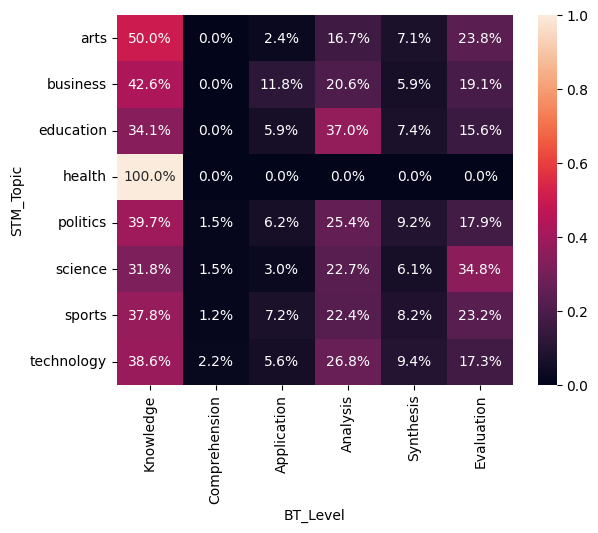

In [80]:
jokes_topic_counts = pd.crosstab(jokesds.STM_Topic, jokesds.BT_Level)[level_list]
jokes_topic_normalized = jokes_topic_counts.div(jokes_topic_counts.sum(axis=1), axis=0)
sns.heatmap(jokes_topic_normalized, annot=True, fmt='.1%')

<Axes: xlabel='BT_Level', ylabel='STM_Topic'>

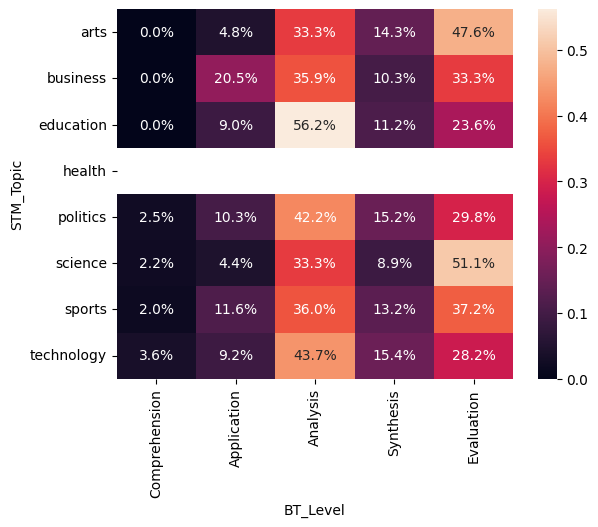

In [81]:
jokes_topic_counts = pd.crosstab(jokesds.STM_Topic, jokesds.BT_Level)[level_list[1:]]
jokes_topic_normalized = jokes_topic_counts.div(jokes_topic_counts.sum(axis=1), axis=0)
sns.heatmap(jokes_topic_normalized, annot=True, fmt='.1%')

## Stanford Question Answering Dataset

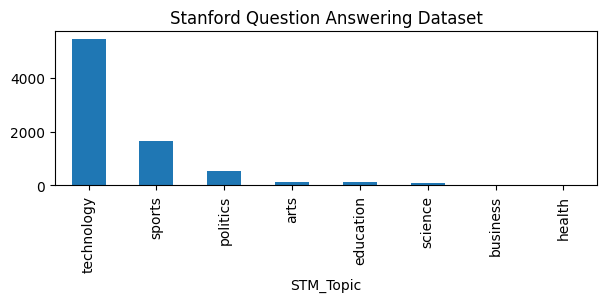

In [82]:
STM_histogram(squadds, 'Stanford Question Answering Dataset')

In [83]:
latex_table(analysis_stm(squadds)[0])

\begin{tabular}{lllllll}
\hline
            & inf\_droberta   & inf\_minilm     & inf\_mpnet      & CU            & DSI            & MAD            \\
\hline
 overall    & 0.699 ± 0.129  & 0.672 ± 0.106  & 0.642 ± 0.107  & 0.658 ± 0.119 & 0.793 ± 0.0243 & 0.83 ± 0.0564  \\
 arts       & 0.734 ± 0.118  & 0.713 ± 0.116  & 0.671 ± 0.106  & 0.709 ± 0.112 & 0.794 ± 0.0221 & 0.817 ± 0.0692 \\
 business   & 0.75 ± 0.0961  & 0.752 ± 0.0725 & 0.728 ± 0.0639 & 0.712 ± 0.107 & 0.799 ± 0.0265 & 0.822 ± 0.0662 \\
 education  & 0.67 ± 0.142   & 0.672 ± 0.105  & 0.615 ± 0.116  & 0.656 ± 0.127 & 0.794 ± 0.0234 & 0.809 ± 0.0582 \\
 health     & 0.918 ± nan    & 0.86 ± nan     & 0.616 ± nan    & 0.769 ± nan   & 0.805 ± nan    & nan ± nan      \\
 politics   & 0.737 ± 0.151  & 0.703 ± 0.121  & 0.67 ± 0.121   & 0.689 ± 0.109 & 0.793 ± 0.0261 & 0.822 ± 0.0519 \\
 science    & 0.689 ± 0.124  & 0.693 ± 0.101  & 0.627 ± 0.108  & 0.667 ± 0.127 & 0.795 ± 0.025  & 0.787 ± 0.052  \\
 sports     & 0.728 ± 0.128  &

C:\Users\kmarc\AppData\Local\Temp\ipykernel_61260\594911413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_ds['Topic'] = ds.STM_Topic


In [84]:
latex_table(analysis_stm(squadds)[1])

\begin{tabular}{lllllll}
\hline
            & inf\_droberta   & inf\_minilm    & inf\_mpnet     & CU            & DSI           & MAD           \\
\hline
 overall    & 0.313 ÷ 1.22   & 0.277 ÷ 1.19  & 0.263 ÷ 1.21  & 0.116 ÷ 0.943 & 0.639 ÷ 0.848 & 0.486 ÷ 0.966 \\
 arts       & 0.493 ÷ 1.11   & 0.307 ÷ 1.02  & 0.369 ÷ 0.974 & 0.286 ÷ 0.933 & 0.721 ÷ 0.837 & 0.621 ÷ 0.953 \\
 business   & 0.596 ÷ 0.97   & 0.641 ÷ 0.879 & 0.643 ÷ 0.824 & 0.5 ÷ 0.842   & 0.734 ÷ 0.826 & 0.72 ÷ 0.899  \\
 education  & 0.325 ÷ 1.03   & 0.363 ÷ 0.942 & 0.35 ÷ 0.903  & 0.217 ÷ 0.897 & 0.711 ÷ 0.84  & 0.656 ÷ 0.929 \\
 health     & 0.918 ÷ 0.918  & 0.86 ÷ 0.86   & 0.616 ÷ 0.616 & 0.769 ÷ 0.769 & 0.805 ÷ 0.805 & nan ÷ nan     \\
 politics   & 0.399 ÷ 1.22   & 0.374 ÷ 1.12  & 0.354 ÷ 1.14  & 0.316 ÷ 0.943 & 0.653 ÷ 0.844 & 0.594 ÷ 0.951 \\
 science    & 0.435 ÷ 0.987  & 0.431 ÷ 0.889 & 0.263 ÷ 0.826 & 0.318 ÷ 0.855 & 0.707 ÷ 0.83  & 0.616 ÷ 0.884 \\
 sports     & 0.357 ÷ 1.15   & 0.277 ÷ 1.19  & 0.328 ÷ 1.21  &

C:\Users\kmarc\AppData\Local\Temp\ipykernel_61260\594911413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_ds['Topic'] = ds.STM_Topic


<Axes: xlabel='BT_Level', ylabel='STM_Topic'>

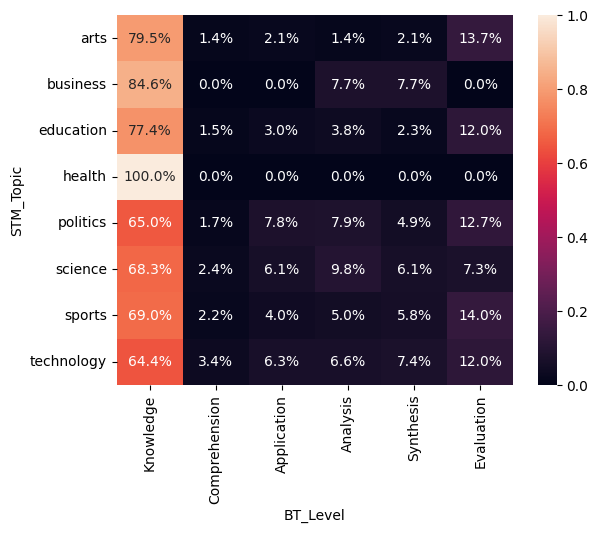

In [85]:
squad_topic_counts = pd.crosstab(squadds.STM_Topic, squadds.BT_Level)[level_list]
squad_topic_normalized = squad_topic_counts.div(squad_topic_counts.sum(axis=1), axis=0)
sns.heatmap(squad_topic_normalized, annot=True, fmt='.1%')

<Axes: xlabel='BT_Level', ylabel='STM_Topic'>

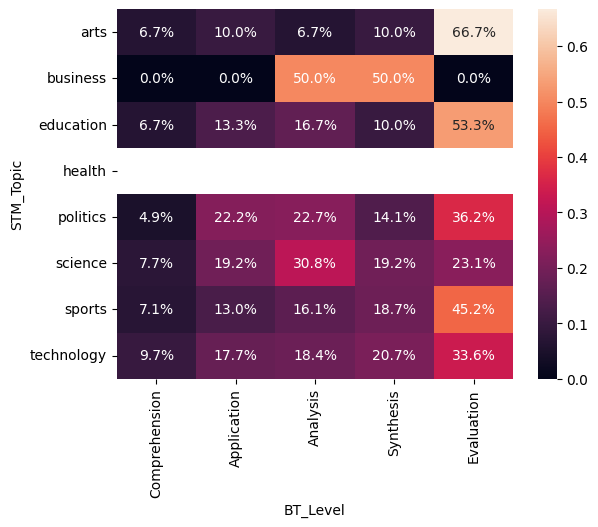

In [86]:
squad_topic_counts = pd.crosstab(squadds.STM_Topic, squadds.BT_Level)[level_list[1:]]
squad_topic_normalized = squad_topic_counts.div(squad_topic_counts.sum(axis=1), axis=0)
sns.heatmap(squad_topic_normalized, annot=True, fmt='.1%')